In [8]:
import sys
import pandas as pd
sys.path.append('../src')
from icedrift.analysis import compute_strain_rate_components
import matplotlib.pyplot as plt

In this notebook, we calculate sea ice deformation from a set of 3 buoys deployed during the MOSAiC expedition. Prior to deformation calculation, the buoys need to be regridded to a common time access. Interpolated and cleaned buoy tracks for the MOSAiC L1, L2, and L3 sites are saved in `data/interp_mosaic_buoys`.

In [2]:
files = ['L1_300234068704730_2019T67.csv',
         'L2_300234068705730_2019T65.csv',
         'L3_300234066081170_2019S94.csv']
buoy_data = {}
for f in files:
    buoy_data[f.split('_')[0]] = pd.read_csv('../data/interp_mosaic_buoys/' + f,
                               index_col=0, parse_dates=True)

In [4]:
strain_rates = compute_strain_rate_components(['L1', 'L2', 'L3'], buoy_data)

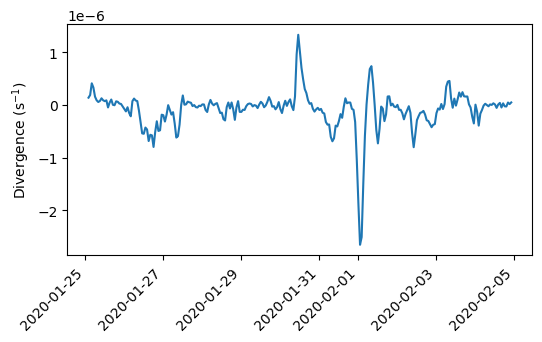

In [13]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(strain_rates['divergence'])
ax.set_ylabel('Divergence (s$^{-1}$)')
plt.xticks(rotation=45, ha='right');

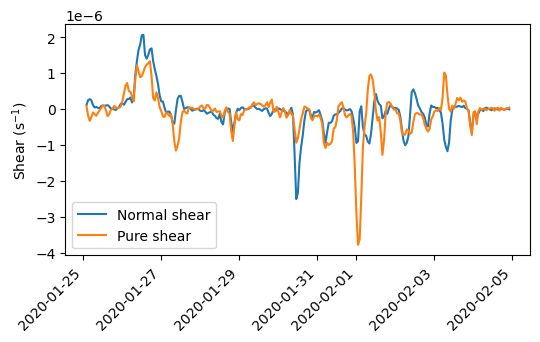

In [15]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(strain_rates['normal_shear'], label='Normal shear')
ax.plot(strain_rates['pure_shear'], label='Pure shear')
ax.set_ylabel('Shear (s$^{-1}$)')
ax.legend()
plt.xticks(rotation=45, ha='right');


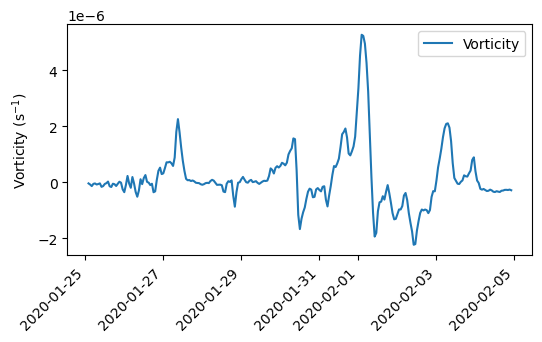

In [16]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(strain_rates['vorticity'], label='Vorticity')
ax.set_ylabel('Vorticity (s$^{-1}$)')
ax.legend()
plt.xticks(rotation=45, ha='right');


In [18]:
strain_rates.to_csv('../data/test_Lsite_strainrates.csv')